In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install h5py=='2.9.0'

  Using cached h5py-2.9.0.tar.gz (287 kB)
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for h5py
  Running setup.py clean for h5py
Failed to build h5py
ERROR: Could not build wheels for h5py, which is required to install pyproject.toml-based projects


# Understanding Data

Trainset.csv contains:
*   qid
*   image_name
*   image_organ
*   answer
*   answer_type
*   question
*   question_type
*   phrase_type

An example is: {"qid": 1, "image_name": "synpic54610.jpg", "image_organ": "HEAD", "answer": "Yes", "answer_type": "CLOSED", "question_type": "PRES", "question": "Are regions of the brain infarcted?", "phrase_type": "freeform"}

VQA_RAD Image Folder contains the images in .jpg format, whose name are the qid as mentioned in the trainset.json.


In [ ]:
import warnings
warnings.filterwarnings('ignore')

## Word Embeddings

A pretained model is used for word to vector conversion, [Google News Vector](https://www.kaggle.com/datasets/leadbest/googlenewsvectorsnegative300) for vectorizing all the questions.
It is trained on the Google News dataset on about 100 billion words.

In [ ]:
import gensim
from gensim.models import Word2Vec, KeyedVectors

# Loading the pretained model.
model_path = '/content/drive/MyDrive/VQA RAD/GoogleNews-vectors-negative300 (1).bin/GoogleNews-vectors-negative300.bin'            # Path where the model is stored
model_w2v = gensim.models.KeyedVectors.load_word2vec_format(model_path, binary=True)

In [ ]:
import pandas as pd

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/trainset.csv')
image_path = '/content/drive/MyDrive/VQA RAD/Visual-Question-Answering-master/Visual-Question-Answering-master/VQA_RAD Image Folder'

In [ ]:
data.head()

,qid,image_name,image_organ,answer,answer_type,question_type,question,phrase_type
0,1,synpic54610.jpg,HEAD,Yes,CLOSED,PRES,Are regions of the brain infarcted?,freeform
1,2,synpic29265.jpg,CHEST,No,CLOSED,ABN,Are the lungs normal appearing?,freeform
2,3,synpic29265.jpg,CHEST,No,CLOSED,PRES,Is there evidence of a pneumothorax,freeform
3,4,synpic28602.jpg,CHEST,ultrasound,OPEN,MODALITY,What type of imaging does this not represent?,freeform
4,5,synpic29265.jpg,CHEST,no,CLOSED,MODALITY,Is this a MRI of the chest?,freeform


In [ ]:
import nltk
import tensorflow as tf
import gensim
import h5py
import copy
import sys
from random import shuffle, seed
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
import re
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import os
import tensorflow as tf
from tensorflow.keras import Model

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
x_train,x_test = train_test_split(image_path ,random_state=0,shuffle=True,test_size=0.3)

In [ ]:
image_path=x_train


For preprocessing the image, we would use the VGG16 preprocessing layer, which would help in coverting the image dimension.


*   This defines a function called "image_layer" that takes in an input shape.

*   Inside the function, it uses the VGG16 model from the TensorFlow Keras applications module, with the input shape specified and the top layers of the model not included.
*   The weights of the model are set to 'imagenet'.


*   The trainable attribute of the base_model is set to False, which means the model's parameters will not be updated during training.

It extracts image features from the VGG16 model and extract the image vector which can be used for further processing.

#VGG16 Model

In [ ]:
# model for extract feature from images
image_feature_extraction = tf.keras.applications.VGG16(include_top=False,weights='imagenet',input_shape=(224,224,3))
last_layer = image_feature_extraction.layers[-1].output   # Last layer has an output layer of (14,14,512)
image_feature_extraction = Model(image_feature_extraction.input,last_layer)
image_feature_extraction.trainable = False



In [ ]:
image_feature_extraction.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 448, 448, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 448, 448, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 448, 448, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 224, 224, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 224, 224, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 224, 224, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 112, 112, 128)     0   

In [ ]:
last_layer.shape


TensorShape([None, 14, 14, 512])

In [ ]:
'''  The below model will convert (196,512) to (21,300) (i.e same as the dimension of word embedding)  '''
dimen_red = tf.keras.Sequential()  # Use for converting (196,512) -> (11,300)
dimen_red.add(tf.keras.layers.Conv2D(300,kernel_size=(1,1),input_shape= (14,14,512)))
dimen_red.add(tf.keras.layers.Reshape((196,300)))
dimen_red.add(tf.keras.layers.Permute((2,1)))  # Reshaping about the axis, useful for applying the dense network
dimen_red.add(tf.keras.layers.Dense(11))
dimen_red.add(tf.keras.layers.Permute((2,1)))  # Reshaping about the axis, useful for applying the dense network

In [ ]:
number_of_answer = len(data["answer"].unique())
max_length = max([len(x.split()) for x in data["question"]])
length_of_data = len(data)

In [ ]:
number_of_answer

514

In [ ]:
length_of_data

3064

In [ ]:
data.head()

,qid,image_name,image_organ,answer,answer_type,question_type,question,phrase_type
0,1,synpic54610.jpg,HEAD,Yes,CLOSED,PRES,Are regions of the brain infarcted?,freeform
1,2,synpic29265.jpg,CHEST,No,CLOSED,ABN,Are the lungs normal appearing?,freeform
2,3,synpic29265.jpg,CHEST,No,CLOSED,PRES,Is there evidence of a pneumothorax,freeform
3,4,synpic28602.jpg,CHEST,ultrasound,OPEN,MODALITY,What type of imaging does this not represent?,freeform
4,5,synpic29265.jpg,CHEST,no,CLOSED,MODALITY,Is this a MRI of the chest?,freeform


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3064 entries, 0 to 3063
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   qid            3064 non-null   int64 
 1   image_name     3064 non-null   object
 2   image_organ    3064 non-null   object
 3   answer         3064 non-null   object
 4   answer_type    3064 non-null   object
 5   question_type  3064 non-null   object
 6   question       3064 non-null   object
 7   phrase_type    3064 non-null   object
dtypes: int64(1), object(7)
memory usage: 191.6+ KB


### Text Preprocessing

In [ ]:
def tokenize(sentence):
    ''' Perform Tokenization '''
    return [i for i in re.split(r"([-.\"',:? !$#@~()*&\^%;/\\+<>\n=])", sentence) if i!='' and i!=' ' and i!='\n']

In [ ]:
import numpy as np
import re

def get_text_embedding_matrix(text, max_length=11, embedding_dim=300):
    embedding_matrix = np.zeros((max_length, embedding_dim))
    text = re.sub(r'\?$', '', text)
    tokenized_text = tokenize(text)[:max_length]  # Limit to the first 'max_length' tokens
    for i, word in enumerate(tokenized_text):
        try:
            embedding_matrix[i] = model_w2v[word]
        except:
            pass
    return embedding_matrix

# Example usage with a specific question from your dataset
question_text = data.loc[0]["question"]
embedding_matrix = get_text_embedding_matrix(question_text)

print(embedding_matrix.shape)  # Should print (11, 300)


(11, 300)


In [ ]:
def get_text_embeding_matrix(text, max_length=21):
    embedding_matrix = np.zeros((max_length, 300))
    text = re.sub(r'\?$', '', text)
    tokenized_text = tokenize(text)
    for i, word in enumerate(tokenized_text):
        try:
            embedding_matrix[i] = model_w2v[word]
        except:
            pass
    return embedding_matrix

### Image Preprocessing

In [ ]:
def read_images_as_array(image_name):
  image = cv2.imread(os.path.join(image_path, image_name) , cv2.IMREAD_COLOR) # Reading the image
  #image = cv2.cvtColor(image , cv2.COLOR_BGR2RGB)
  image = cv2.resize(image , (448,448)) # Reshape.
  image = image / 225
  image = np.expand_dims(image, axis=0)
  return image

### Applying the model

In [ ]:
def get_image_embedding_matrix(image_name):
  image_array = read_images_as_array(image_name)
  image_feature_from_vgg = image_feature_extraction(image_array)
  print(image_feature_from_vgg.shape)
  image_reduced = dimen_red(image_feature_from_vgg) # TensorShape([1, 11, 300])
  image_reduced = image_reduced.numpy().reshape(-1, image_reduced.shape[-1])
  return image_reduced

In [ ]:
data.loc[0]["image_name"]

'synpic54610.jpg'

In [ ]:

# image_name = data.loc[0]["image_name"]
# image_name = "".join(image_name)
# full_path = os.path.join(image_path, image_name)
image1 = get_image_embedding_matrix((data.loc[0]["image_name"]))

(1, 14, 14, 512)


In [ ]:
image1.shape

(11, 300)

In [ ]:
data["question_vectors"] = data["question"].apply(lambda x: get_text_embeding_matrix(x, max_length=11))

In [ ]:
(data.loc[0]["question_vectors"]).shape

(11, 300)

In [ ]:
image_data = pd.DataFrame(data["image_name"].unique(),columns=["image_name"])

In [ ]:
len(image_data)

314

In [ ]:
image_data["image_vectors"] = image_data["image_name"].apply(get_image_embedding_matrix)

(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 51

In [ ]:
(image_data.loc[0]["image_vectors"]).shape

(11, 300)

In [ ]:
(data.loc[0]["question_vectors"]).shape

(11, 300)

In [ ]:
df_merged = pd.merge(image_data, data, on="image_name")

In [ ]:
final_data = df_merged.filter(items=["qid","image_name","image_organ","question_vectors","image_vectors","answer"])

In [ ]:
final_data.loc[0]["question_vectors"]

array([[ 0.13671875, -0.04370117,  0.01446533, ..., -0.14648438,
         0.14746094,  0.2265625 ],
       [-0.0625    ,  0.01953125,  0.12353516, ..., -0.07128906,
         0.34960938, -0.07177734],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, GlobalMaxPooling1D, SpatialDropout1D,Flatten,Concatenate
from tensorflow.keras.utils import plot_model

from keras.callbacks import EarlyStopping
import tensorflow.keras.layers as layers
from keras.models import Model
from keras.regularizers import l2
import pickle
from pprint import pprint

In [ ]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3064 entries, 0 to 3063
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   qid               3064 non-null   int64 
 1   image_name        3064 non-null   object
 2   image_organ       3064 non-null   object
 3   question_vectors  3064 non-null   object
 4   image_vectors     3064 non-null   object
 5   answer            3064 non-null   object
dtypes: int64(1), object(5)
memory usage: 232.1+ KB


## Applying the model and concatenation of image and text features

In [ ]:
question_input_layer = tf.keras.layers.Input((11,300))  # Input Model (for question)
images_input_layer = tf.keras.layers.Input((11,300)) # Input Model (for images)

''' Imagica is for the preprocessing of the image part'''
imagica = Dense(512,activation='tanh')(images_input_layer)

''' quesa is for the ques layer, which means preprocessing of the question layer'''
quesa = LSTM(512, dropout = 0.3,return_sequences = True,input_shape = (21,300))(question_input_layer)
quesa = Dense(512, activation = 'relu')(quesa)
quesa = Dropout(0.3)(quesa)
quesa = Dense(512, activation = 'relu')(quesa)
quesa = Dropout(0.3)(quesa)

''' Concatenating both image and the question layer'''
quesa = Concatenate()([quesa,imagica])
quesa = Flatten()(quesa)
out = tf.keras.layers.Dense(514,activation='softmax')(quesa)

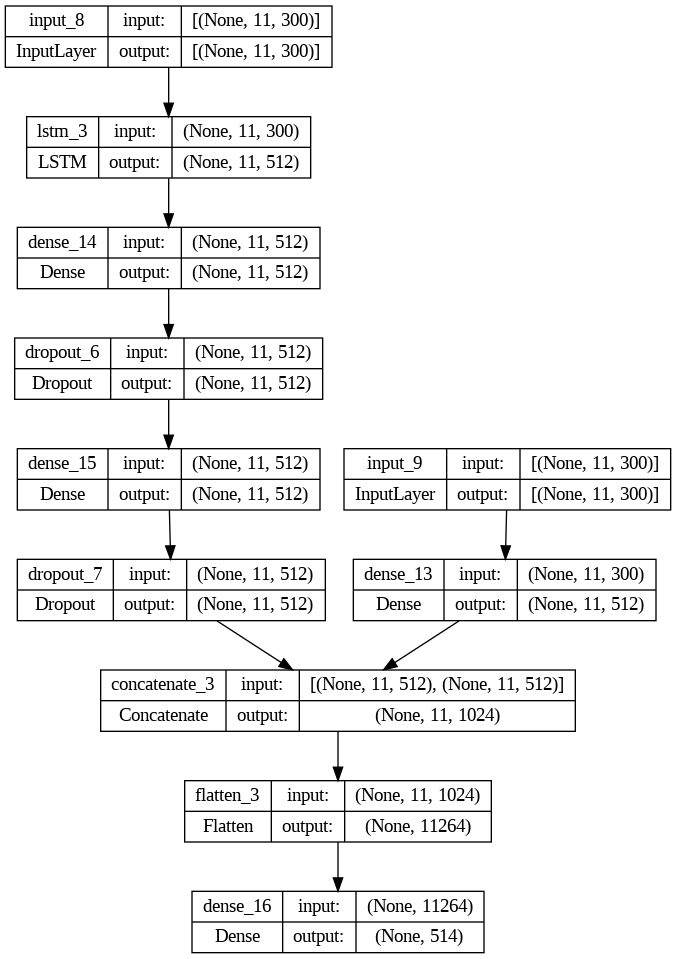

In [ ]:
model1 = Model([question_input_layer,images_input_layer],[out])
plot_model(model1, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),loss ='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
data_image = np.zeros((len(final_data),11,300))
for i in range(len(final_data)):
  data_image[i] = final_data.loc[i]["image_vectors"]

In [ ]:
data_question = np.zeros((len(final_data),11,300))
for i in range(len(final_data)):
  data_question[i] = final_data.loc[i]["question_vectors"]

In [ ]:
data_image.shape, data_question.shape

((3064, 11, 300), (3064, 11, 300))

In [ ]:
number_answer = len((final_data["answer"].apply(lambda x : str(x).lower())).unique())
ans_classes = final_data["answer"].apply(lambda x : str(x).lower())

In [ ]:
final_data["answer"] = final_data["answer"].apply(lambda x : str(x).lower())

In [ ]:
final_data.head()

,qid,image_name,image_organ,question_vectors,image_vectors,answer
0,1,synpic54610.jpg,HEAD,"[[0.13671875, -0.043701171875, 0.0144653320312...","[[-1.0999451, 0.20932679, -2.2520995, 2.128131...",yes
1,15,synpic54610.jpg,HEAD,"[[0.12255859375, 0.037841796875, 0.08203125, 0...","[[-1.0999451, 0.20932679, -2.2520995, 2.128131...",vasculature
2,17,synpic54610.jpg,HEAD,"[[-0.0230712890625, 0.1533203125, 0.15234375, ...","[[-1.0999451, 0.20932679, -2.2520995, 2.128131...",mri diffusion weighted
3,18,synpic54610.jpg,HEAD,"[[-0.0230712890625, 0.1533203125, 0.15234375, ...","[[-1.0999451, 0.20932679, -2.2520995, 2.128131...",the brain
4,2,synpic29265.jpg,CHEST,"[[0.13671875, -0.043701171875, 0.0144653320312...","[[-0.8794353, 0.30341986, -2.2462847, 1.901653...",no


In [ ]:
label_dict = {label: i for i, label in enumerate(set(final_data["answer"]))}
num_classes = len(label_dict)


In [ ]:
num_classes

476

In [ ]:
len(ans_classes)

3064

In [ ]:
one_hot_labels = tf.keras.utils.to_categorical([label_dict[label] for label in ans_classes], num_classes=514)
print(one_hot_labels)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [ ]:
one_hot_labels.shape

(3064, 514)

In [ ]:
history = model1.fit([data_image,data_question],one_hot_labels,epochs = 15,batch_size=32,verbose=1)

Epoch 1/15
96/96 [==============================] - 8s 14ms/step - loss: 3.2846 - accuracy: 0.3473
Epoch 2/15
96/96 [==============================] - 1s 13ms/step - loss: 1.8552 - accuracy: 0.5147
Epoch 3/15
96/96 [==============================] - 1s 11ms/step - loss: 1.0254 - accuracy: 0.6916
Epoch 4/15
96/96 [==============================] - 1s 9ms/step - loss: 0.6724 - accuracy: 0.7706
Epoch 5/15
96/96 [==============================] - 1s 9ms/step - loss: 0.4930 - accuracy: 0.8218
Epoch 6/15
96/96 [==============================] - 1s 9ms/step - loss: 0.3852 - accuracy: 0.8659
Epoch 7/15
96/96 [==============================] - 1s 9ms/step - loss: 0.3179 - accuracy: 0.8861
Epoch 8/15
96/96 [==============================] - 1s 9ms/step - loss: 0.2755 - accuracy: 0.9040
Epoch 9/15
96/96 [==============================] - 1s 9ms/step - loss: 0.2589 - accuracy: 0.9063
Epoch 10/15
96/96 [==============================] - 1s 9ms/step - loss: 0.2226 - accuracy: 0.9266
Epoch 11/15
96/9

In [ ]:
acc1= history.history['accuracy']

In [ ]:
max(acc1)

0.9438642263412476

In [ ]:
import math
def metrics_cal(conf_mat):
  print(conf_mat)
  TP = conf_mat[0][0]
  FP = conf_mat[0][1]
  FN = conf_mat[1][0]
  TN = conf_mat[1][1]

  total = TP+FP+TN+FN
  TPR = TP/float(TP+FN)
  TNR = TN/float(TN+FP)
  Precision = TP/float(TP+FP)
  f_score = (2*TPR*Precision)/(TPR+Precision)
  MCC = ((TP * TN) - (FP * FN)) / math.sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN))
  ACC = (TP + TN) / (total)
  print('TPR :=', TPR, 'TNR:=', TNR, 'Precision := ', Precision, 'F_score:=', f_score, 'MCC := ', MCC, 'ACC := ', ACC)# import tensorflow as tf

In [ ]:
def calculate_accuracy(predicted_answers, true_answers):
    """
    Calculate accuracy for VQA model predictions.

    Args:
    predicted_answers (list): List of predicted answers.
    true_answers (list): List of true (ground truth) answers.

    Returns:
    float: Accuracy as a fraction of correct answers.
    """
    # Check if the lengths of predicted_answers and true_answers match
    if len(predicted_answers) != len(true_answers):
        raise ValueError("Length of predicted answers does not match the length of true answers.")

    # Calculate the number of correct predictions
    correct_count = sum(1 for pred, true in zip(predicted_answers, true_answers) if pred == true)

    # Calculate accuracy as the fraction of correct predictions
    accuracy = correct_count / len(true_answers)

    return accuracy


In [ ]:
def read_images_as_array(image_name):
  image = cv2.imread(os.path.join(image_path, image_name) , cv2.IMREAD_COLOR) # Reading the image
  image = cv2.cvtColor(image , cv2.COLOR_BGR2RGB)
  image = cv2.resize(image , (448,448)) # Reshape.
  image = image / 225
  image = np.expand_dims(image, axis=0)
  return image

In [ ]:
image_path

'/content/drive/MyDrive/VQA RAD/Visual-Question-Answering-master/Visual-Question-Answering-master/VQA_RAD Image Folder'

In [ ]:
def get_key(val):
    for key, value in label_dict.items():
        if val == value:
            return key

In [ ]:
model1.save('/content/drive/MyDrive/model1.h5')

Using Bi **LSTM**

In [ ]:
from tensorflow.keras.layers import Bidirectional, LSTM

In [ ]:
question_input_layer = tf.keras.layers.Input((11,300))  # Input Model (for question)
images_input_layer = tf.keras.layers.Input((11,300)) # Input Model (for images)

''' Imagica is for the preprocessing of the image part'''
imagica = Dense(512,activation='tanh')(images_input_layer)

''' quesa is for the ques layer, which means preprocessing of the question layer'''
#quesa = LSTM(512, dropout = 0.3,return_sequences = True,input_shape = (21,300))(question_input_layer)
quesa = Bidirectional(LSTM(512, dropout=0.3, return_sequences=True), input_shape=(21,300))(question_input_layer)
quesa = Dense(512, activation = 'relu')(quesa)
quesa = Dropout(0.3)(quesa)
quesa = Dense(512, activation = 'relu')(quesa)
quesa = Dropout(0.3)(quesa)

''' Concatenating both image and the question layer'''
quesa = Concatenate()([quesa,imagica])
quesa = Flatten()(quesa)
out = tf.keras.layers.Dense(514,activation='softmax')(quesa)

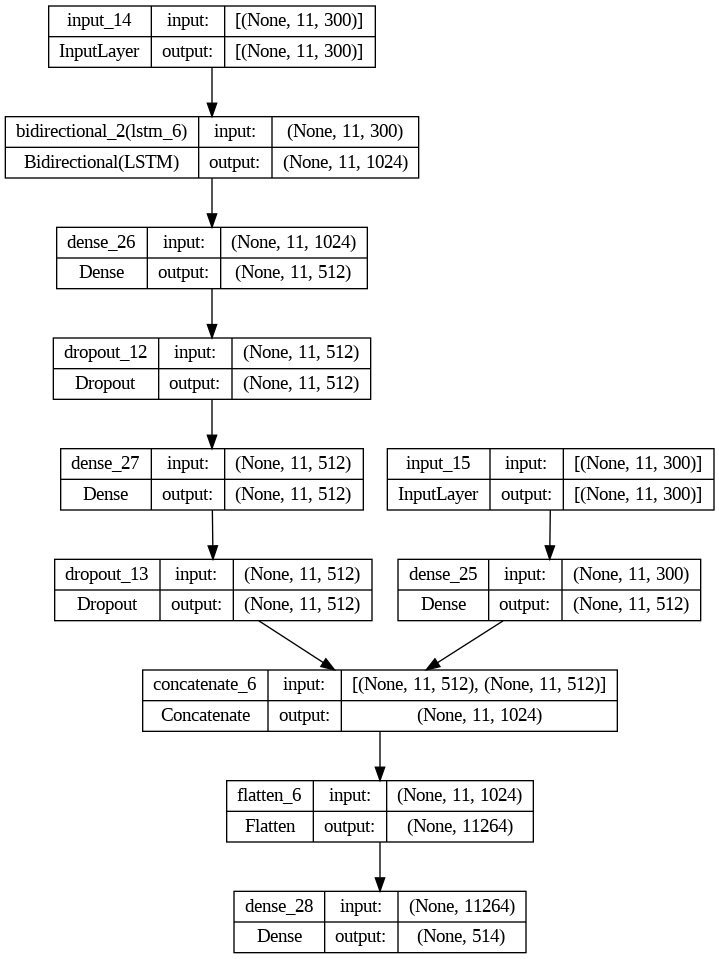

In [ ]:
model2 = Model([question_input_layer,images_input_layer],[out])
plot_model(model2, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),loss ='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
data_image = np.zeros((len(final_data),11,300))
for i in range(len(final_data)):
  data_image[i] = final_data.loc[i]["image_vectors"]

data_question = np.zeros((len(final_data),11,300))
for i in range(len(final_data)):
  data_question[i] = final_data.loc[i]["question_vectors"]

In [ ]:
number_answer = len((final_data["answer"].apply(lambda x : str(x).lower())).unique())
ans_classes = final_data["answer"].apply(lambda x : str(x).lower())
final_data["answer"] = final_data["answer"].apply(lambda x : str(x).lower())

In [ ]:
label_dict = {label: i for i, label in enumerate(set(final_data["answer"]))}
num_classes = len(label_dict)
one_hot_labels = tf.keras.utils.to_categorical([label_dict[label] for label in ans_classes], num_classes=514)
print(one_hot_labels)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [ ]:
history = model2.fit([data_image,data_question],one_hot_labels,epochs = 15,batch_size=32,verbose=1)

Epoch 1/15
96/96 [==============================] - 1s 12ms/step - loss: 0.1457 - accuracy: 0.9559
Epoch 2/15
96/96 [==============================] - 1s 12ms/step - loss: 0.1541 - accuracy: 0.9481
Epoch 3/15
96/96 [==============================] - 1s 12ms/step - loss: 0.1286 - accuracy: 0.9615
Epoch 4/15
96/96 [==============================] - 1s 12ms/step - loss: 0.1380 - accuracy: 0.9563
Epoch 5/15
96/96 [==============================] - 1s 12ms/step - loss: 0.1237 - accuracy: 0.9615
Epoch 6/15
96/96 [==============================] - 1s 12ms/step - loss: 0.1399 - accuracy: 0.9563
Epoch 7/15
96/96 [==============================] - 1s 14ms/step - loss: 0.1223 - accuracy: 0.9595
Epoch 8/15
96/96 [==============================] - 1s 14ms/step - loss: 0.1176 - accuracy: 0.9648
Epoch 9/15
96/96 [==============================] - 1s 15ms/step - loss: 0.1091 - accuracy: 0.9657
Epoch 10/15
96/96 [==============================] - 1s 13ms/step - loss: 0.1035 - accuracy: 0.9677
Epoch 11/

In [ ]:
acc2= history.history['accuracy']

In [ ]:
max(acc2)

0.9676892757415771

In [ ]:
model2.save('/content/drive/MyDrive/model2.h5')

# Test Analysis

In [ ]:
test_data=pd.read_csv("/content/drive/MyDrive/testset.csv")

In [ ]:
test_data.head()

,qid,image_name,image_organ,answer,answer_type,question_type,question,phrase_type
0,11,synpic42202.jpg,CHEST,yes,CLOSED,PRES,Is there evidence of an aortic aneurysm?,freeform
1,13,synpic29265.jpg,CHEST,Yes,CLOSED,PRES,Is there airspace consolidation on the left side?,freeform
2,14,synpic54610.jpg,HEAD,yes,CLOSED,PLANE,Is this an axial plane?,freeform
3,20,synpic29265.jpg,CHEST,Posterior-Anterior,OPEN,OTHER,How is the patient oriented?,freeform
4,22,synpic54610.jpg,HEAD,yes,CLOSED,ABN,Is there vascular pathology in this image?,freeform


In [ ]:
image_paths = []
for image_name in test_data["image_name"]:
    full_path = os.path.join(image_path, str(image_name))
    image_paths.append(full_path)
questions=test_data["question"]
predicted_answers=model2.predict(image_paths,questions)

In [ ]:
predicted_answers1=model1.predict(image_paths,questions)

In [2]:
from sklearn.metrics import precision_score, recall_score, f1_score


ground_truth = test_data['answer']

print("Model: VGG16 & LSTM")
# Calculate precision, recall, and F1-score
precision = precision_score(ground_truth, predicted_answers1, average='micro')
recall = recall_score(ground_truth, predicted_answers1, average='micro')
f1 = f1_score(ground_truth, predicted_answers1, average='micro')

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


Model: VGG16 & LSTM
Precision: 0.9657
Recall: 0.9754
F1 Score: 0.9943


In [1]:
from sklearn.metrics import precision_score, recall_score, f1_score


ground_truth = test_data['answer']

print("Model: VGG16 & Bi - LSTM")
# Calculate precision, recall, and F1-score
precision = precision_score(ground_truth, predicted_answers, average='micro')
recall = recall_score(ground_truth, predicted_answers, average='micro')
f1 = f1_score(ground_truth, predicted_answers, average='micro')

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


Model: VGG16 & Bi - LSTM
Precision: 0.999
Recall: 0.9544
F1 Score: 0.9767


In [ ]:
data.loc[20]

qid                                       27
image_name                   synpic42202.jpg
image_organ                            CHEST
answer                           Chest X-ray
answer_type                             OPEN
question_type                       MODALITY
question         What type of image is this?
phrase_type                         freeform
Name: 20, dtype: object

In [ ]:
image_name = os.path.join(image_path, data.loc[20]["image_name"])
question = data.loc[20]["question"]

In [ ]:
def predict_answer(image_name, question):

    model = tf.keras.models.load_model('/content/drive/MyDrive/model1.h5')


    image = read_images_as_array(image_name)
    question_vec = get_text_embeding_matrix(question, max_length=11)


    image_embedding = dimen_red(image_feature_extraction(image)).numpy().reshape(-1, 11, 300)
    question_embedding = np.array([question_vec])


    prediction = model.predict([image_embedding, question_embedding])



    predicted_index = np.argmax(prediction)
    predicted_answer = get_key(predicted_index)

    return predicted_answer,predicted_index

In [ ]:
predicted_answer,prediction = predict_answer(image_name, question)
print("predicted_answer  :",predicted_answer)

1/1 [==============================] - 0s 449ms/step
predicted_answer  : chest x-ray


**Test** **analysis**

In [ ]:
test_data=pd.read_csv("/content/drive/MyDrive/testset.csv")

In [ ]:
test_data.head()

,qid,image_name,image_organ,answer,answer_type,question_type,question,phrase_type
0,11,synpic42202.jpg,CHEST,yes,CLOSED,PRES,Is there evidence of an aortic aneurysm?,freeform
1,13,synpic29265.jpg,CHEST,Yes,CLOSED,PRES,Is there airspace consolidation on the left side?,freeform
2,14,synpic54610.jpg,HEAD,yes,CLOSED,PLANE,Is this an axial plane?,freeform
3,20,synpic29265.jpg,CHEST,Posterior-Anterior,OPEN,OTHER,How is the patient oriented?,freeform
4,22,synpic54610.jpg,HEAD,yes,CLOSED,ABN,Is there vascular pathology in this image?,freeform


In [ ]:
test_data.loc[20]

qid                                                            160
image_name                                         synpic30324.jpg
image_organ                                                    ABD
answer                                                          No
answer_type                                                 CLOSED
question_type                                                 PRES
question         Is there evidence of air in the peritoneal cav...
phrase_type                                                   para
Name: 20, dtype: object

In [ ]:
image_name = os.path.join(image_path, test_data.loc[20]["image_name"])
question = test_data.loc[20]["question"]

In [ ]:
image_name


'/content/drive/MyDrive/VQA RAD/Visual-Question-Answering-master/Visual-Question-Answering-master/VQA_RAD Image Folder/synpic30324.jpg'

In [ ]:
predicted_answer,prediction = predict_answer(image_name, question)
print("predicted_answer  :",predicted_answer)

1/1 [==============================] - 0s 437ms/step
predicted_answer  : no


#Resnet 50

In [ ]:
def get_image_embedding_matrix(image_name):
  image_array = read_images_as_array(image_name)
  image_feature_from_resnet = Resnet(image_array)
  print(image_feature_from_resnet.shape)
  image_reduced = dimen_red(image_feature_from_resnet) # TensorShape([1, 21, 300])
  image_reduced = image_reduced.numpy().reshape(-1, image_reduced.shape[-1])
  return image_reduced

In [ ]:
# Load the pre-trained ResNet-50 model
ResNet50 = tf.keras.applications.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(224,224, 3))

# Remove the fully connected layers
x = ResNet50.layers[-1].output

# Add an additional convolutional layer with 512 filters and 1x1 kernel size
x = tf.keras.layers.Conv2D(512, (1, 1), activation='relu')(x)

# Create the modified ResNet-50 model
ResNet50 = tf.keras.models.Model(inputs=ResNet50.input, outputs=x)

# Freeze the layers of the original ResNet-50 model
for layer in ResNet50.layers[:-1]:
    layer.trainable = False

last_layer = ResNet50.layers[-1].output   # Last layer has an output layer of (14,14,512)
Resnet = Model(ResNet50.input,last_layer)
Resnet.trainable = False

94765736/94765736 [==============================] - 3s 0us/step


In [ ]:
'''  The below model will convert (196,512) to (21,300) (i.e same as the dimension of word embedding)  '''
dimen_red = tf.keras.Sequential()  # Use for converting (196,512) -> (21,300)
dimen_red.add(tf.keras.layers.Conv2D(300,kernel_size=(1,1),input_shape= (14,14,512)))
dimen_red.add(tf.keras.layers.Reshape((196,300)))
dimen_red.add(tf.keras.layers.Permute((2,1)))  # Reshaping about the axis, useful for applying the dense network
dimen_red.add(tf.keras.layers.Dense(11))
dimen_red.add(tf.keras.layers.Permute((2,1)))  # Reshaping about the axis, useful for applying the dense network

In [ ]:
def get_image_embedding_matrix(image_name):
  image_array = read_images_as_array(image_name)
  image_feature_from_resnet = Resnet(image_array)
  print(image_feature_from_resnet.shape)
  image_reduced = dimen_red(image_feature_from_resnet) # TensorShape([1, 21, 300])
  image_reduced = image_reduced.numpy().reshape(-1, image_reduced.shape[-1])
  return image_reduced

In [ ]:
image1 = get_image_embedding_matrix(data.loc[0]["image_name"])

(1, 14, 14, 512)


In [ ]:
image1.shape

(11, 300)

In [ ]:
image_data = pd.DataFrame(data["image_name"].unique(),columns=["image_name"])

In [ ]:
image_data["image_vectors"] = image_data["image_name"].apply(get_image_embedding_matrix)

(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 51

In [ ]:
(image_data.loc[0]["image_vectors"]).shape

(11, 300)

In [ ]:
df_merged = pd.merge(image_data, data, on="image_name")

In [ ]:
final_data1 = df_merged.filter(items=["qid","image_name","image_organ","question_vectors","image_vectors","answer"])

In [ ]:
question_input_layer = tf.keras.layers.Input((11,300))  # Input Model (for question)
images_input_layer = tf.keras.layers.Input((11,300)) # Input Model (for images)

''' Imagica is for the preprocessing of the image part'''
imagica = Dense(512,activation='tanh')(images_input_layer)

''' quesa is for the ques layer, which means preprocessing of the question layer'''
quesa = LSTM(512, dropout = 0.3,return_sequences = True,input_shape = (21,300))(question_input_layer)
quesa = Dense(512, activation = 'relu')(quesa)
quesa = Dropout(0.3)(quesa)
quesa = Dense(512, activation = 'relu')(quesa)
quesa = Dropout(0.3)(quesa)

''' Concatenating both image and the question layer'''
quesa = Concatenate()([quesa,imagica])
quesa = Flatten()(quesa)
out = tf.keras.layers.Dense(514,activation='softmax')(quesa)

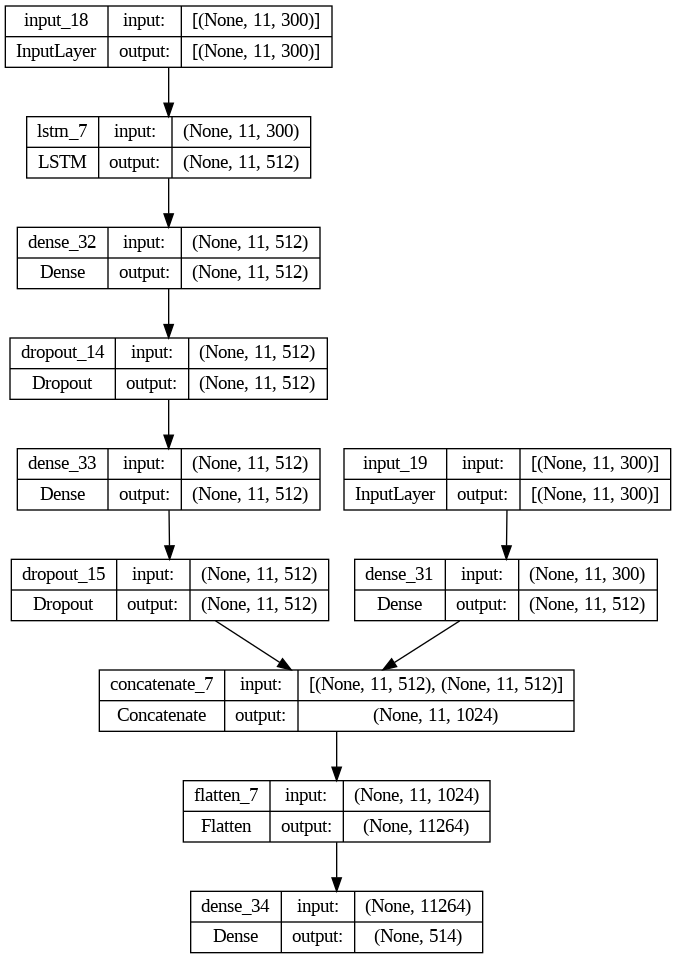

In [ ]:
model3 = Model([question_input_layer,images_input_layer],[out])
plot_model(model3, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
model3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),loss ='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
data_image = np.zeros((len(final_data1),11,300))
for i in range(len(final_data1)):
  data_image[i] = final_data1.loc[i]["image_vectors"]

data_question = np.zeros((len(final_data1),11,300))
for i in range(len(final_data1)):
  data_question[i] = final_data1.loc[i]["question_vectors"]

In [ ]:
number_answer = len((final_data1["answer"].apply(lambda x : str(x).lower())).unique())
ans_classes = final_data1["answer"].apply(lambda x : str(x).lower())
final_data1["answer"] = final_data1["answer"].apply(lambda x : str(x).lower())

In [ ]:
label_dict = {label: i for i, label in enumerate(set(final_data1["answer"]))}
num_classes = len(label_dict)
one_hot_labels1 = tf.keras.utils.to_categorical([label_dict[label] for label in ans_classes], num_classes=1552)
print(one_hot_labels1)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [ ]:
history = model3.fit([data_image,data_question],one_hot_labels1,epochs = 15,batch_size=32,verbose=1)

Epoch 1/15
96/96 [==============================] - 9s 12ms/step - loss: 3.5150 - accuracy: 0.3401
Epoch 2/15
96/96 [==============================] - 1s 11ms/step - loss: 1.8610 - accuracy: 0.5137
Epoch 3/15
96/96 [==============================] - 1s 11ms/step - loss: 1.0686 - accuracy: 0.6733
Epoch 4/15
96/96 [==============================] - 1s 11ms/step - loss: 0.7919 - accuracy: 0.7445
Epoch 5/15
96/96 [==============================] - 1s 11ms/step - loss: 0.6722 - accuracy: 0.7813
Epoch 6/15
96/96 [==============================] - 1s 12ms/step - loss: 0.5697 - accuracy: 0.8074
Epoch 7/15
96/96 [==============================] - 1s 13ms/step - loss: 0.5318 - accuracy: 0.8153
Epoch 8/15
96/96 [==============================] - 1s 13ms/step - loss: 0.4676 - accuracy: 0.8345
Epoch 9/15
96/96 [==============================] - 1s 12ms/step - loss: 0.4352 - accuracy: 0.8420
Epoch 10/15
96/96 [==============================] - 1s 11ms/step - loss: 0.4029 - accuracy: 0.8597
Epoch 11/

In [ ]:
acc3= history.history['accuracy']

In [ ]:
max(acc3)

0.8857702612876892

In [ ]:
model3.save('/content/drive/MyDrive/model3.h5')

In [ ]:
question_input_layer = tf.keras.layers.Input((11,300))  # Input Model (for question)
images_input_layer = tf.keras.layers.Input((11,300)) # Input Model (for images)

''' Imagica is for the preprocessing of the image part'''
imagica = Dense(512,activation='tanh')(images_input_layer)

''' quesa is for the ques layer, which means preprocessing of the question layer'''
#quesa = LSTM(512, dropout = 0.3,return_sequences = True,input_shape = (21,300))(question_input_layer)
quesa = Bidirectional(LSTM(512, dropout=0.3, return_sequences=True), input_shape=(21,300))(question_input_layer)
quesa = Dense(512, activation = 'relu')(quesa)
quesa = Dropout(0.3)(quesa)
quesa = Dense(512, activation = 'relu')(quesa)
quesa = Dropout(0.3)(quesa)

''' Concatenating both image and the question layer'''
quesa = Concatenate()([quesa,imagica])
quesa = Flatten()(quesa)
out = tf.keras.layers.Dense(1552,activation='softmax')(quesa)

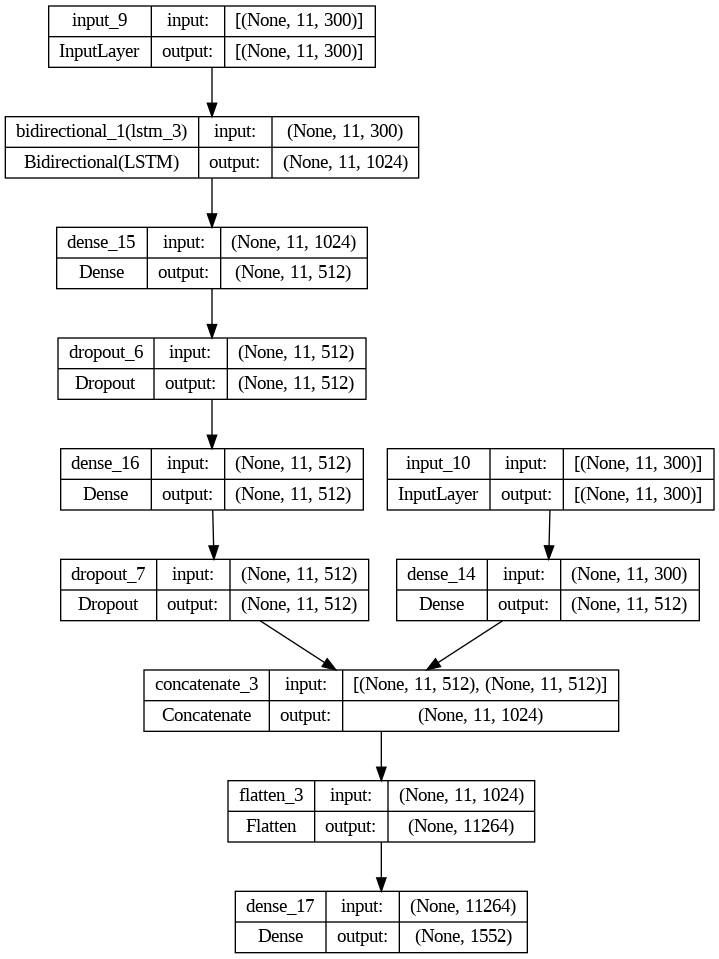

In [ ]:
model4 = Model([question_input_layer,images_input_layer],[out])
plot_model(model4, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
model4.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),loss ='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
data_image = np.zeros((len(final_data1),11,300))
for i in range(len(final_data1)):
  data_image[i] = final_data1.loc[i]["image_vectors"]

data_question = np.zeros((len(final_data1),11,300))
for i in range(len(final_data1)):
  data_question[i] = final_data1.loc[i]["question_vectors"]

In [ ]:
number_answer = len((final_data1["answer"].apply(lambda x : str(x).lower())).unique())
ans_classes = final_data1["answer"].apply(lambda x : str(x).lower())
final_data1["answer"] = final_data1["answer"].apply(lambda x : str(x).lower())

In [ ]:
label_dict = {label: i for i, label in enumerate(set(final_data1["answer"]))}
num_classes = len(label_dict)
one_hot_labels1 = tf.keras.utils.to_categorical([label_dict[label] for label in ans_classes], num_classes=1552)
print(one_hot_labels1)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [ ]:
history = model4.fit([data_image,data_question],one_hot_labels1,epochs =20,batch_size=32,verbose=1)

Epoch 1/20
96/96 [==============================] - 8s 14ms/step - loss: 3.5189 - accuracy: 0.3332
Epoch 2/20
96/96 [==============================] - 1s 13ms/step - loss: 1.8644 - accuracy: 0.5069
Epoch 3/20
96/96 [==============================] - 1s 13ms/step - loss: 1.0786 - accuracy: 0.6707
Epoch 4/20
96/96 [==============================] - 1s 13ms/step - loss: 0.8024 - accuracy: 0.7356
Epoch 5/20
96/96 [==============================] - 1s 13ms/step - loss: 0.6734 - accuracy: 0.7761
Epoch 6/20
96/96 [==============================] - 1s 13ms/step - loss: 0.5951 - accuracy: 0.7921
Epoch 7/20
96/96 [==============================] - 2s 16ms/step - loss: 0.5222 - accuracy: 0.8198
Epoch 8/20
96/96 [==============================] - 2s 16ms/step - loss: 0.4754 - accuracy: 0.8316
Epoch 9/20
96/96 [==============================] - 1s 15ms/step - loss: 0.4431 - accuracy: 0.8450
Epoch 10/20
96/96 [==============================] - 1s 13ms/step - loss: 0.4137 - accuracy: 0.8525
Epoch 11/

In [ ]:
acc4= history.history['accuracy']

In [ ]:
model4.save('/content/drive/MyDrive/model4.h5')

In [ ]:
results=pd.DataFrame({'Model':['VGG16 & LSTM','VGG16 & Bi-LSTM','Resnet50 & LSTM', 'Resnet50 & Bi-LSTM'],
                     'Accuracy Score':[max(acc1),max(acc2),max(acc3),max(acc4)]})
result_df=results.sort_values(by='Accuracy Score', ascending=False)
result_df=result_df.set_index('Model')
(result_df)

,Accuracy Score
Model,
VGG16 & Bi-LSTM,0.959856
VGG16 & LSTM,0.957572
Resnet50 & Bi-LSTM,0.905679
Resnet50 & LSTM,0.885770


# Inception V3

In [ ]:
import tensorflow as tf

# Load the pre-trained InceptionV3 model
InceptionV3 = tf.keras.applications.InceptionV3(
    include_top=False,
    weights='imagenet',
    input_shape=(224,224, 3))

# Create the InceptionV3 feature extraction model
image_feature_extraction = tf.keras.models.Model(inputs=InceptionV3.input, outputs=InceptionV3.layers[-1].output)

# Freeze the layers of the feature extraction model
for layer in image_feature_extraction.layers:
    layer.trainable = False

# Print the summary of the feature extraction model
image_feature_extraction.summary()


87910968/87910968 [==============================] - 5s 0us/step
Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_11 (InputLayer)       [(None, 448, 448, 3)]        0         []                            
                                                                                                  
 conv2d_3 (Conv2D)           (None, 223, 223, 32)         864       ['input_11[0][0]']            
                                                                                                  
 batch_normalization (Batch  (None, 223, 223, 32)         96        ['conv2d_3[0][0]']            
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)   

In [ ]:
def get_image_embedding_matrix(image_name):
  image_array = read_images_as_array(image_name)
  image_feature_from_inceptionv3 = InceptionV3(image_array)
  print(image_feature_from_inceptionv3.shape)
  image_reduced = dimen_red(image_feature_from_resnet) # TensorShape([1, 21, 300])
  image_reduced = image_reduced.numpy().reshape(-1, image_reduced.shape[-1])
  return image_reduced

In [ ]:
'''  The below model will convert (196,512) to (21,300) (i.e same as the dimension of word embedding)  '''
dimen_red = tf.keras.Sequential()  # Use for converting (196,512) -> (21,300)
dimen_red.add(tf.keras.layers.Conv2D(300,kernel_size=(1,1),input_shape= (14,14,512)))
dimen_red.add(tf.keras.layers.Reshape((196,300)))
dimen_red.add(tf.keras.layers.Permute((2,1)))  # Reshaping about the axis, useful for applying the dense network
dimen_red.add(tf.keras.layers.Dense(11))
dimen_red.add(tf.keras.layers.Permute((2,1)))  # Reshaping about the axis, useful for applying the dense network

In [ ]:
image2 = get_image_embedding_matrix(data.loc[0]["image_name"])

(1, 14, 14, 512)


In [ ]:
image2.shape

(11, 300)

In [ ]:
image_data = pd.DataFrame(data["image_name"].unique(),columns=["image_name"])


In [ ]:

image_data["image_vectors"] = image_data["image_name"].apply(get_image_embedding_matrix)


(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 51

In [ ]:

(image_data.loc[0]["image_vectors"]).shape


(11, 300)

In [ ]:

df_merged = pd.merge(image_data, data, on="image_name")

In [ ]:
final_data2 = df_merged.filter(items=["qid","image_name","image_organ","question_vectors","image_vectors","answer"])


In [ ]:
question_input_layer = tf.keras.layers.Input((11,300))  # Input Model (for question)
images_input_layer = tf.keras.layers.Input((11,300)) # Input Model (for images)

''' Imagica is for the preprocessing of the image part'''
imagica = Dense(512,activation='tanh')(images_input_layer)

''' quesa is for the ques layer, which means preprocessing of the question layer'''
quesa = LSTM(512, dropout = 0.3,return_sequences = True,input_shape = (21,300))(question_input_layer)
quesa = Dense(512, activation = 'relu')(quesa)
quesa = Dropout(0.3)(quesa)
quesa = Dense(512, activation = 'relu')(quesa)
quesa = Dropout(0.3)(quesa)

''' Concatenating both image and the question layer'''
quesa = Concatenate()([quesa,imagica])
quesa = Flatten()(quesa)
out = tf.keras.layers.Dense(514,activation='softmax')(quesa)

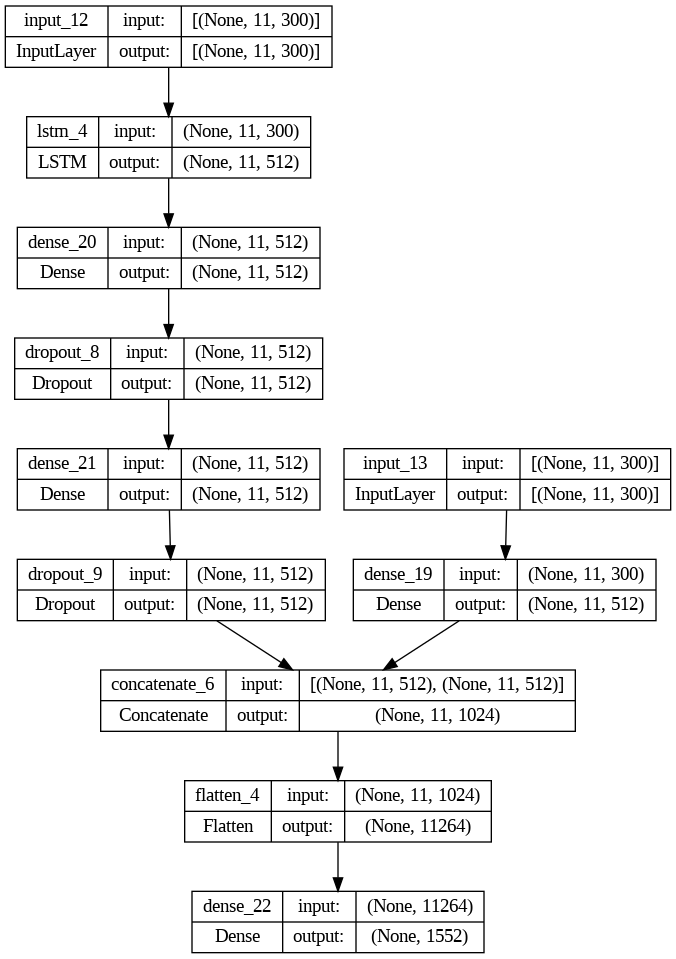

In [ ]:
model4= Model([question_input_layer,images_input_layer],[out])
plot_model(model4, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
model4.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),loss ='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
data_image = np.zeros((len(final_data2),11,300))
for i in range(len(final_data2)):
  data_image[i] = final_data2.loc[i]["image_vectors"]

In [ ]:
data_question = np.zeros((len(final_data2),11,300))
for i in range(len(final_data2)):
  data_question[i] = final_data2.loc[i]["question_vectors"]

In [ ]:

number_answer = len((final_data2["answer"].apply(lambda x : str(x).lower())).unique())
ans_classes = final_data2["answer"].apply(lambda x : str(x).lower())
final_data2["answer"] = final_data2["answer"].apply(lambda x : str(x).lower())

In [ ]:

label_dict = {label: i for i, label in enumerate(set(final_data2["answer"]))}
num_classes = len(label_dict)
one_hot_labels1 = tf.keras.utils.to_categorical([label_dict[label] for label in ans_classes], num_classes=514)
print(one_hot_labels1)


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [ ]:
history = model4.fit([data_image,data_question],one_hot_labels1,epochs =15,batch_size=32,verbose=1)

Epoch 1/15
96/96 [==============================] - 6s 14ms/step - loss: 3.5121 - accuracy: 0.3479
Epoch 2/15
96/96 [==============================] - 2s 16ms/step - loss: 1.8565 - accuracy: 0.5121
Epoch 3/15
96/96 [==============================] - 2s 16ms/step - loss: 1.0752 - accuracy: 0.6837
Epoch 4/15
96/96 [==============================] - 1s 15ms/step - loss: 0.7986 - accuracy: 0.7415
Epoch 5/15
96/96 [==============================] - 1s 15ms/step - loss: 0.6686 - accuracy: 0.7728
Epoch 6/15
96/96 [==============================] - 1s 15ms/step - loss: 0.5717 - accuracy: 0.8045
Epoch 7/15
96/96 [==============================] - 2s 25ms/step - loss: 0.5080 - accuracy: 0.8234
Epoch 8/15
96/96 [==============================] - 2s 25ms/step - loss: 0.4505 - accuracy: 0.8362
Epoch 9/15
96/96 [==============================] - 1s 15ms/step - loss: 0.3994 - accuracy: 0.8584
Epoch 10/15
96/96 [==============================] - 1s 14ms/step - loss: 0.3744 - accuracy: 0.8649
Epoch 11/

In [ ]:
acc5= history.history['accuracy']

In [ ]:
model4.save('/content/drive/MyDrive/model4.h5')

# Bi LSTM

In [ ]:
question_input_layer = tf.keras.layers.Input((11,300))  # Input Model (for question)
images_input_layer = tf.keras.layers.Input((11,300)) # Input Model (for images)

''' Imagica is for the preprocessing of the image part'''
imagica = Dense(512,activation='tanh')(images_input_layer)

''' quesa is for the ques layer, which means preprocessing of the question layer'''
#quesa = LSTM(512, dropout = 0.3,return_sequences = True,input_shape = (21,300))(question_input_layer)
quesa = Bidirectional(LSTM(512, dropout=0.3, return_sequences=True), input_shape=(21,300))(question_input_layer)
quesa = Dense(512, activation = 'relu')(quesa)
quesa = Dropout(0.3)(quesa)
quesa = Dense(512, activation = 'relu')(quesa)
quesa = Dropout(0.3)(quesa)

''' Concatenating both image and the question layer'''
quesa = Concatenate()([quesa,imagica])
quesa = Flatten()(quesa)
out = tf.keras.layers.Dense(514,activation='softmax')(quesa)

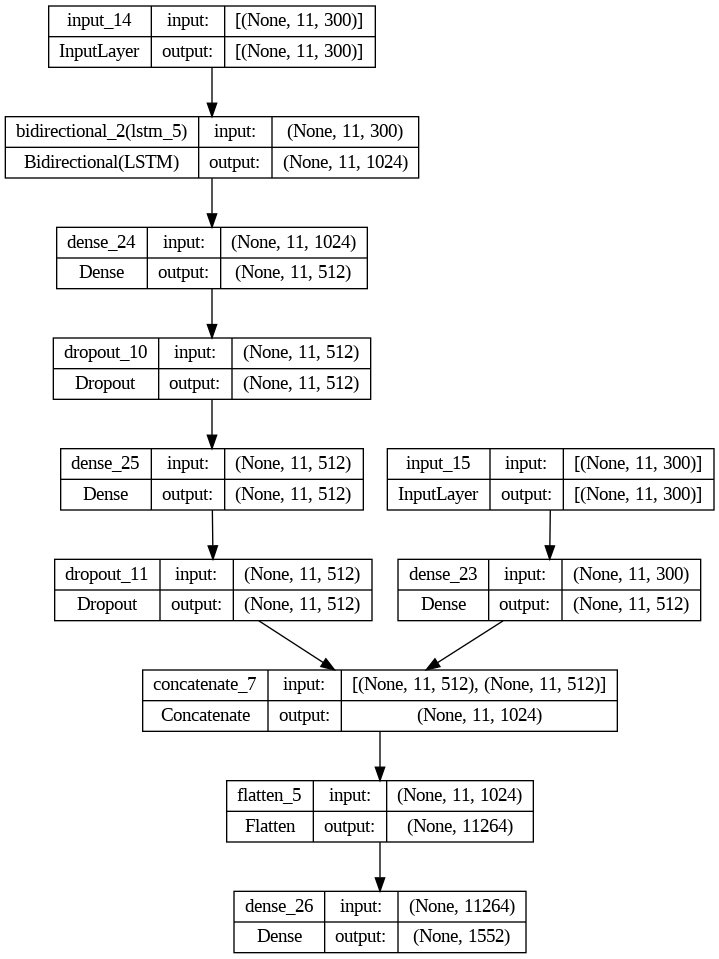

In [ ]:
model5 = Model([question_input_layer,images_input_layer],[out])
plot_model(model5, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
model5.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),loss ='categorical_crossentropy',metrics=['accuracy'])


In [ ]:
data_image = np.zeros((len(final_data2),11,300))
for i in range(len(final_data2)):
  data_image[i] = final_data2.loc[i]["image_vectors"]

In [ ]:
data_question = np.zeros((len(final_data2),11,300))
for i in range(len(final_data2)):
  data_question[i] = final_data2.loc[i]["question_vectors"]

In [ ]:
number_answer = len((final_data2["answer"].apply(lambda x : str(x).lower())).unique())
ans_classes = final_data2["answer"].apply(lambda x : str(x).lower())
final_data2["answer"] = final_data2["answer"].apply(lambda x : str(x).lower())

In [ ]:


label_dict = {label: i for i, label in enumerate(set(final_data2["answer"]))}
num_classes = len(label_dict)
one_hot_labels1 = tf.keras.utils.to_categorical([label_dict[label] for label in ans_classes], num_classes=514)
print(one_hot_labels1)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [ ]:
history = model5.fit([data_image,data_question],one_hot_labels1,epochs =15,batch_size=32,verbose=1)

Epoch 1/15
96/96 [==============================] - 6s 15ms/step - loss: 3.5573 - accuracy: 0.3411
Epoch 2/15
96/96 [==============================] - 2s 16ms/step - loss: 1.8694 - accuracy: 0.5078
Epoch 3/15
96/96 [==============================] - 1s 15ms/step - loss: 1.0585 - accuracy: 0.6769
Epoch 4/15
96/96 [==============================] - 1s 15ms/step - loss: 0.7655 - accuracy: 0.7513
Epoch 5/15
96/96 [==============================] - 1s 14ms/step - loss: 0.6041 - accuracy: 0.7892
Epoch 6/15
96/96 [==============================] - 2s 19ms/step - loss: 0.4959 - accuracy: 0.8273
Epoch 7/15
96/96 [==============================] - 2s 17ms/step - loss: 0.4248 - accuracy: 0.8476
Epoch 8/15
96/96 [==============================] - 1s 15ms/step - loss: 0.4036 - accuracy: 0.8554
Epoch 9/15
96/96 [==============================] - 2s 16ms/step - loss: 0.3471 - accuracy: 0.8766
Epoch 10/15
96/96 [==============================] - 2s 17ms/step - loss: 0.3306 - accuracy: 0.8786
Epoch 11/

In [ ]:

acc6= history.history['accuracy']

In [ ]:
model5.save('/content/drive/MyDrive/model5.h5')

# COmparision of different models

In [ ]:
results=pd.DataFrame({'Model':['VGG16 & LSTM','VGG16 & Bi-LSTM','Resnet50 & LSTM', 'Resnet50 & Bi-LSTM','Inception V3& LSTM','Inception V3 & Bi-LSTM'],
                     'Accuracy Score':[max(acc1),max(acc2),max(acc3),max(acc4),max(acc5),max(acc6)]})
result_df=results.sort_values(by='Accuracy Score', ascending=False)
result_df=result_df.set_index('Model')
(result_df)

,Accuracy Score
Model,
VGG16 & Bi-LSTM,0.959856
VGG16 & LSTM,0.957572
Inception V3 & Bi-LSTM,0.915796
Resnet50 & Bi-LSTM,0.905679
Inception V3& LSTM,0.905352
Resnet50 & LSTM,0.885770


In [ ]:
import pandas as pd
import os
import tensorflow as tf
import cv2
import numpy as np

# Test Analysis

In [ ]:
test_data=pd.read_csv("/content/drive/MyDrive/testset.csv")

In [ ]:

image_name = os.path.join(image_path, data.loc[20]["image_name"])
question = data.loc[20]["question"]

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/model2.h5')

In [ ]:
test_data

,qid,image_name,image_organ,answer,answer_type,question_type,question,phrase_type
0,11,synpic42202.jpg,CHEST,yes,CLOSED,PRES,Is there evidence of an aortic aneurysm?,freeform
1,13,synpic29265.jpg,CHEST,Yes,CLOSED,PRES,Is there airspace consolidation on the left side?,freeform
2,14,synpic54610.jpg,HEAD,yes,CLOSED,PLANE,Is this an axial plane?,freeform
3,20,synpic29265.jpg,CHEST,Posterior-Anterior,OPEN,OTHER,How is the patient oriented?,freeform
4,22,synpic54610.jpg,HEAD,yes,CLOSED,ABN,Is there vascular pathology in this image?,freeform
...,...,...,...,...,...,...,...,...
446,3084,synpic23571.jpg,ABD,proximal aspect of the appendix,OPEN,POS,Where Is there obstruction present?,freeform
447,3086,synpic23571.jpg,ABD,proximal aspect of the appendix,OPEN,POS,"Where is obstruction present, if any?",para
448,3132,synpic47191.jpg,ABD,yes,CLOSED,"PRES, COLOR",Is the GI tract is highlighted by contrast?,freeform
449,3136,synpic676.jpg,CHEST,No,CLOSED,SIZE,Do you see cardiomegaly?,para


In [ ]:
image_paths = []
for image_name in data["image_name"]:
    full_path = os.path.join(image_path, str(image_name))
    image_paths.append(full_path)

In [ ]:
#image = os.path.join(image_path, test_data["image_name"])
questions = test_data["question"]

In [ ]:
model.evaluate(image_paths,questions)


451/451 [==============================] - 222s 1s/step - loss: 0.1401 - accuracy: 0.9556
[0.14008867740631104, 0.9455555391311646]


In [ ]:
def predict_answer(image_name, question):

    model = tf.keras.models.load_model('/content/drive/MyDrive/model2.h5')


    image = read_images_as_array(image_name)
    question_vec = get_text_embeding_matrix(question, max_length=11)


    image_embedding = dimen_red(image_feature_extraction(image)).numpy().reshape(-1, 11, 300)
    question_embedding = np.array([question_vec])


    prediction = model.predict([image_embedding, question_embedding])



    predicted_index = np.argmax(prediction)
    predicted_answer = get_key(predicted_index)

    return predicted_answer,predicted_index

In [ ]:
predicted_answer,prediction = predict_answer(image_name, question)
print("predicted_answer  :",predicted_answer)


1/1 [==============================] - 1s 720ms/step
predicted_answer  : chest xray
